# CMAM Dataset Visualization and Cleaning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [2]:
df = pd.read_csv('cmam_data.csv')
print(f"Original dataset: {len(df)} rows")
df.head(10)

Original dataset: 4000 rows


,child_id,visit_date,sex,age_months,muac_mm,edema,appetite,danger_signs,label_pathway
0,CH001448,2022-06-03,F,NaN,105,1,good,0,OTP
1,CH001115,2025-09-29,F,10.0,122,0,good,0,TSFP
2,CH001065,2025-09-29,M,29.0,123,0,good,0,TSFP
3,CH002288,2023-01-26,M,21.0,107,0,poor,0,SC_ITP
4,CH001538,2023-09-12,F,NaN,105,0,good,0,OTP
5,CH000669,2025-03-30,F,NaN,123,0,good,0,TSFP
6,CH002405,2022-01-26,M,46.0,106,0,poor,0,SC_ITP
7,CH000498,2024-03-17,M,40.0,120,0,good,0,TSFP
8,CH002481,2022-07-23,M,29.0,99,1,poor,0,SC_ITP
9,CH000472,2024-04-06,F,54.0,122,0,good,0,TSFP


## 2. Data Exploration

In [4]:
print("Pathway Distribution:")
print(df['label_pathway'].value_counts())
print(f"\nAppetite Distribution:")
print(df['appetite'].value_counts())

Pathway Distribution:
label_pathway
TSFP      1846
OTP       1416
SC_ITP     738
Name: count, dtype: int64

Appetite Distribution:
appetite
good    3498
poor     502
Name: count, dtype: int64


## 3. Visualizations

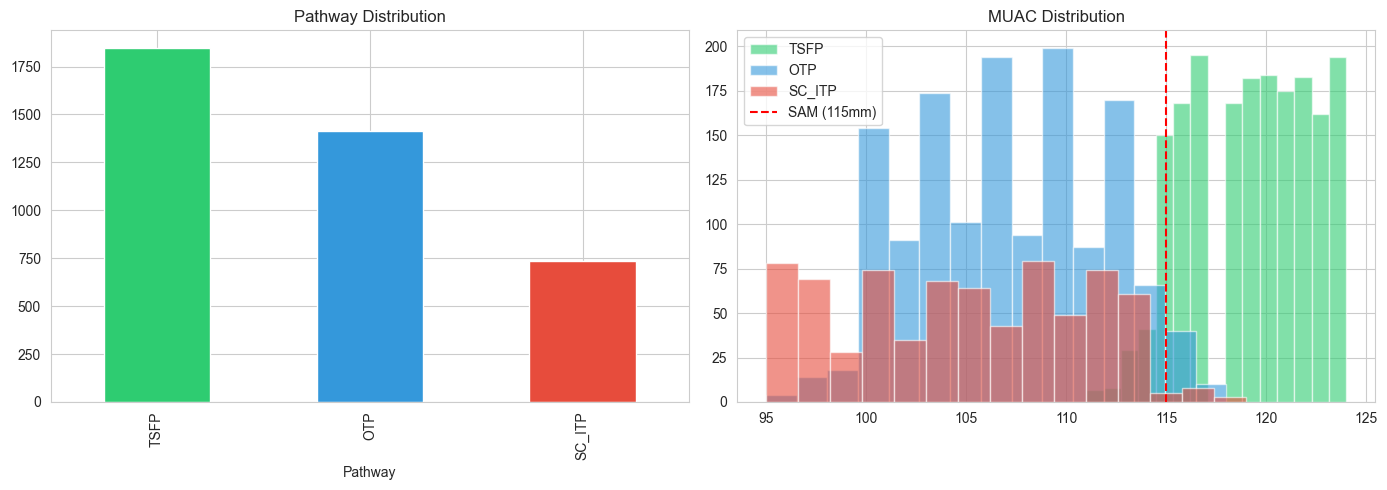

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['label_pathway'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0].set_title('Pathway Distribution')
axes[0].set_xlabel('Pathway')

for pathway, color in [('TSFP', '#2ecc71'), ('OTP', '#3498db'), ('SC_ITP', '#e74c3c')]:
    subset = df[df['label_pathway'] == pathway]['muac_mm']
    axes[1].hist(subset, bins=15, alpha=0.6, label=pathway, color=color)
axes[1].axvline(115, color='red', linestyle='--', label='SAM (115mm)')
axes[1].set_title('MUAC Distribution')
axes[1].legend()
plt.tight_layout()
plt.show()

## 4. Check Rule Violations

In [6]:
SAM_THRESHOLD = 115
MAM_LOWER = 115
MAM_UPPER = 125

def verify_cmam_rules(row):
    muac = row['muac_mm']
    edema = row['edema']
    appetite = row['appetite']
    danger = row['danger_signs']
    label = row['label_pathway']
    
    is_sam = (muac < SAM_THRESHOLD) or (edema == 1)
    
    if label == 'TSFP':
        return (MAM_LOWER <= muac < MAM_UPPER and edema == 0 and appetite == 'good' and danger == 0)
    if label == 'OTP':
        return (is_sam and appetite == 'good' and danger == 0)
    if label == 'SC_ITP':
        return (is_sam and (appetite == 'poor' or danger == 1))
    return False

df['valid'] = df.apply(verify_cmam_rules, axis=1)
violations = df[~df['valid']]
print(f"Total violations: {len(violations)} ({len(violations)/len(df)*100:.1f}%)")

Total violations: 136 (3.4%)


## 5. Cleaning

In [9]:
print("CLEANING PIPELINE")
print("=" * 70)

df['visit_date'] = pd.to_datetime(df['visit_date'])
df['year'] = df['visit_date'].dt.year

df_clean = df[df['appetite'] != 'unknown'].copy()
print(f"After removing unknown appetite: {len(df_clean)} rows")

df_clean['valid'] = df_clean.apply(verify_cmam_rules, axis=1)
df_clean = df_clean[df_clean['valid']].copy()
print(f"After removing violations: {len(df_clean)} rows")

df_clean = df_clean.drop(columns=['valid', 'year', 'danger_signs_list', 'facility'], errors='ignore')
df_clean = df_clean[['child_id', 'visit_date', 'sex', 'age_months', 'muac_mm', 'edema', 'appetite', 'danger_signs', 'label_pathway']]

print(f"\nFinal: {len(df_clean)} rows")
print(df_clean['label_pathway'].value_counts())

CLEANING PIPELINE
After removing unknown appetite: 4000 rows
After removing violations: 3864 rows

Final: 3864 rows
label_pathway
TSFP      1761
OTP       1374
SC_ITP     729
Name: count, dtype: int64


## 6. Save

In [10]:
df_clean.to_csv('cmam_4000_realistic_clean.csv', index=False)
print(f"✓ Saved: cmam_4000_realistic_clean.csv")
print(f"✓ {len(df_clean)} rows")
print(f"✓ 100% CMAM compliant")

✓ Saved: cmam_4000_realistic_clean.csv
✓ 3864 rows
✓ 100% CMAM compliant
